# TUGAS BESAR MACHINE LEARNING
oleh:
- Gede Bagus Krishnanditya Merta (1301223088)
- Raka Aditya Waluya (1301220192)
- Dody Adi Sancoko (1301223071)

## Overview
Proyek ini bertujuan untuk membangun model Machine Learning guna memprediksi kemungkinan seseorang terkena stroke berdasarkan fitur-fitur seperti usia, jenis kelamin, status merokok, hipertensi, dan lain-lain.

Dataset yang digunakan merupakan dataset **Stroke Prediction** yang tersedia di Kaggle, dan analisis ini mencakup tahapan mulai dari eksplorasi data, pembersihan data, pemodelan, hingga evaluasi performa model.

---


## Dataset
Dataset ini berisi informasi kesehatan dan demografis dari beberapa individu, dengan fitur-fitur seperti:

- `gender` : jenis kelamin  
- `age` : usia  
- `hypertension` : memiliki hipertensi atau tidak  
- `heart_disease` : memiliki penyakit jantung atau tidak  
- `ever_married` : status pernikahan  
- `work_type` : jenis pekerjaan  
- `Residence_type` : tinggal di daerah urban atau rural  
- `avg_glucose_level` : rata-rata kadar glukosa  
- `bmi` : indeks massa tubuh  
- `smoking_status` : status merokok  
- `stroke` : target variabel, 1 jika pernah mengalami stroke

Sumber dataset: `/kaggle/input/stroke-prediction-dataset`

---

## Import Library

In [1]:
!pip install -U numpy==1.24.4
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0

# Untuk optimasi swarm
!pip install pyswarm

# Untuk optimasi genetic algorithm
!pip install geneticalgorithm

In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Set seaborn dan matplotlib untuk visualisasi
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Cek versi untuk konfirmasi
import sklearn, imblearn
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("numpy:", np.__version__)

scikit-learn: 1.3.2
imbalanced-learn: 0.11.0
numpy: 1.24.4


## Data Understanding
Untuk memahami struktur dan kualitas data, dilakukan proses **Exploratory Data Analysis (EDA)** yang mencakup:


In [4]:
# Load dataset
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

# Tampilkan 5 baris awal
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
print("DATA INFO :")
df.info()

print("Count Unique Data :")
df.nunique()

DATA INFO :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
Count Unique Data :


id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [6]:
print("Missing Value :")
df.isnull().sum()

Missing Value :


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
# Buang kolom 'id'
df = df.drop(columns=['id'])

# Numerik: manual berdasarkan konteks
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']

# Kategorikal: sisanya (kecuali target)
categorical_cols = [col for col in df.columns if col not in numerical_cols + ['stroke']]


In [8]:
df[numerical_cols].describe()

,age,avg_glucose_level,bmi,hypertension,heart_disease
count,5110.000000,5110.000000,4909.000000,5110.000000,5110.000000
mean,43.226614,106.147677,28.893237,0.097456,0.054012
std,22.612647,45.283560,7.854067,0.296607,0.226063
min,0.080000,55.120000,10.300000,0.000000,0.000000
25%,25.000000,77.245000,23.500000,0.000000,0.000000
50%,45.000000,91.885000,28.100000,0.000000,0.000000
75%,61.000000,114.090000,33.100000,0.000000,0.000000
max,82.000000,271.740000,97.600000,1.000000,1.000000


In [9]:
# Untuk menghitung label & count tiap fitur kategorikal
categorical_summary = []

for col in categorical_cols:
    value_counts = df[col].value_counts().reset_index()
    value_counts.columns = ['Label', 'Count']
    value_counts['Feature'] = col
    categorical_summary.append(value_counts)

categorical_summary_df = pd.concat(categorical_summary)[['Feature', 'Label', 'Count']]
categorical_summary_df


,Feature,Label,Count
0,gender,Female,2994
1,gender,Male,2115
2,gender,Other,1
0,ever_married,Yes,3353
1,ever_married,No,1757
0,work_type,Private,2925
1,work_type,Self-employed,819
2,work_type,children,687
3,work_type,Govt_job,657
4,work_type,Never_worked,22


Persentase kelas:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


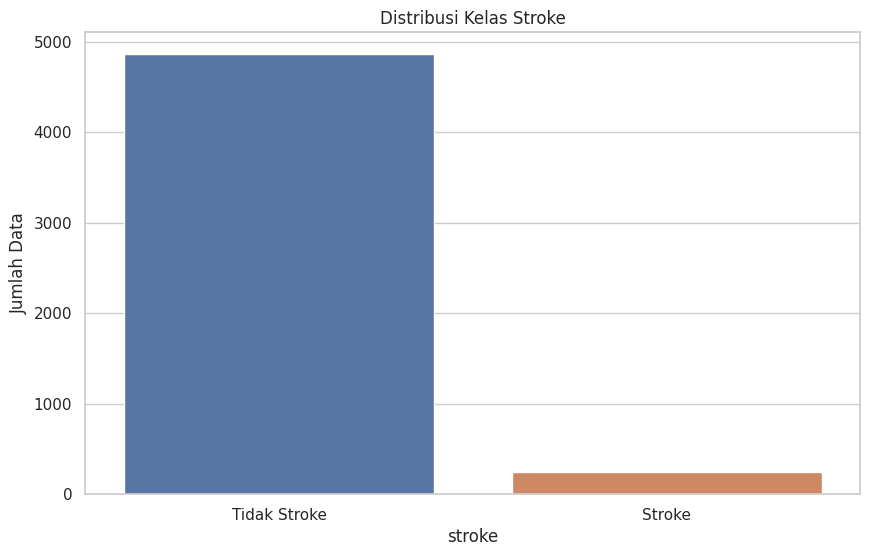

In [10]:
# Cek proporsi data stroke
stroke_counts = df['stroke'].value_counts(normalize=True) * 100
print("Persentase kelas:")
print(stroke_counts)

# Visualisasi distribusi kelas
sns.countplot(data=df, x='stroke')
plt.title('Distribusi Kelas Stroke')
plt.xticks([0, 1], ['Tidak Stroke', 'Stroke'])
plt.ylabel('Jumlah Data')
plt.show()

### INSIGHT dari EDA

Dari hasil analisis data (EDA) didapatkan bahwa
- Terdapat 5110 baris data dalam 12 kolom
- kolom BMI memiliki missing value sebanyak 201
- Gender other berjumlah 11, data ini tidak penting untuk analisis
- Data kategorikal memiliki label yang unik
- Proporsi data untuk kolom prediksi 'stroke' tidak seimbang (imbalance) dengan proporsi sekitar 95 : 5 untuk perbandingan label 1 dan 0.

## Data Preprocessing
Pada tahap ini akan dilakukan data preprocessing sesuai dengan EDA yang telah dilakukan pada dataset

In [11]:
# Copy dataframe & isi nilai kosong
df_clean = df.copy()
df_clean['bmi'].fillna(df_clean['bmi'].median(), inplace=True)

# Buang baris dengan gender = 'Other'
df_clean = df_clean[df_clean['gender'] != 'Other']

# Inisialisasi encoder
le = LabelEncoder()

# Daftar kolom kategorikal (semua selain numerik & target)
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Lakukan label encoding
for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

# Pisahkan fitur dan target
X = df_clean.drop(columns=['stroke'])
y = df_clean['stroke']


/tmp/ipykernel_233/243230705.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['bmi'].fillna(df_clean['bmi'].median(), inplace=True)


In [12]:
df_clean.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,0.413975,43.229986,0.097475,0.054022,0.656293,2.167743,0.508123,106.140399,28.863300,1.376982,0.048738
std,0.492592,22.613575,0.296633,0.226084,0.474991,1.090398,0.499983,45.285004,7.699785,1.071626,0.215340
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,2.000000,0.000000,77.240000,23.800000,0.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,1.000000,2.000000,1.000000,91.880000,28.100000,2.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,3.000000,1.000000,114.090000,32.800000,2.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.600000,3.000000,1.000000


In [13]:
# Ambil semua kolom yang bukan numerik dan bukan target
categorical_cols_after_encoding = [col for col in df_clean.columns if col not in numerical_cols + ['stroke'] and df_clean[col].nunique() <= 20]

# Buat ringkasan count label untuk kolom kategorikal setelah encoding
categorical_summary = []

for col in categorical_cols_after_encoding:
    value_counts = df_clean[col].value_counts().reset_index()
    value_counts.columns = ['Label', 'Count']
    value_counts['Feature'] = col
    categorical_summary.append(value_counts)

categorical_summary_df = pd.concat(categorical_summary)[['Feature', 'Label', 'Count']]
categorical_summary_df


,Feature,Label,Count
0,gender,0,2994
1,gender,1,2115
0,ever_married,1,3353
1,ever_married,0,1756
0,work_type,2,2924
1,work_type,3,819
2,work_type,4,687
3,work_type,0,657
4,work_type,1,22
0,Residence_type,1,2596


### SMOTE dan RandomUnderSampler
Karena data kelas stroke cukup imbalance, maka kami menerapkan metode Synthetic Minority Oversampling Technique (SMOTE) untuk oversampling data minoritas (stroke) dan RandomUnderSampler untuk undersampling data mayoritas (tidak stroke). Hal ini perlu dilakukan untuk menyeimbangkan data, sehingga model akan belajar kelas yang sama secara seimbang dan tidak overfit.

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pandas as pd

# 1. Buat SMOTE dan RandomUnderSampler
# SMOTE akan membuat kelas minoritas jadi 50% dari mayoritas
# Undersampling akan menurunkan kelas mayoritas agar 80% dari total setelah SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

# 2. Buat pipeline gabungan SMOTE dan undersampling
pipeline = Pipeline([
    ('smote', smote),
    ('under', under)
])

# 3. Terapkan pipeline pada data
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# 4. Tampilkan hasil
print("Jumlah label setelah SMOTE + Undersampling:")
print(pd.Series(y_resampled).value_counts())


Jumlah label setelah SMOTE + Undersampling:
stroke
0    3037
1    2430
Name: count, dtype: int64


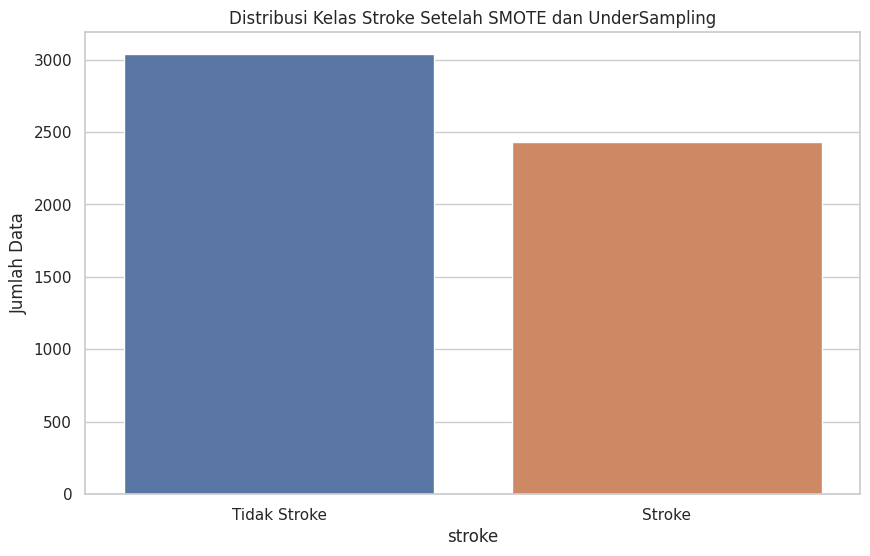

In [55]:
# Buat DataFrame baru dari hasil SMOTE dan RandomUnderSampler
df_resampled = pd.DataFrame(X_resampled, columns=df.drop('stroke', axis=1).columns)
df_resampled['stroke'] = y_resampled

# Visualisasi distribusi kelas setelah oversampling
sns.countplot(data=df_resampled, x='stroke')
plt.title('Distribusi Kelas Stroke Setelah SMOTE dan UnderSampling')
plt.xticks([0, 1], ['Tidak Stroke', 'Stroke'])
plt.ylabel('Jumlah Data')
plt.show()

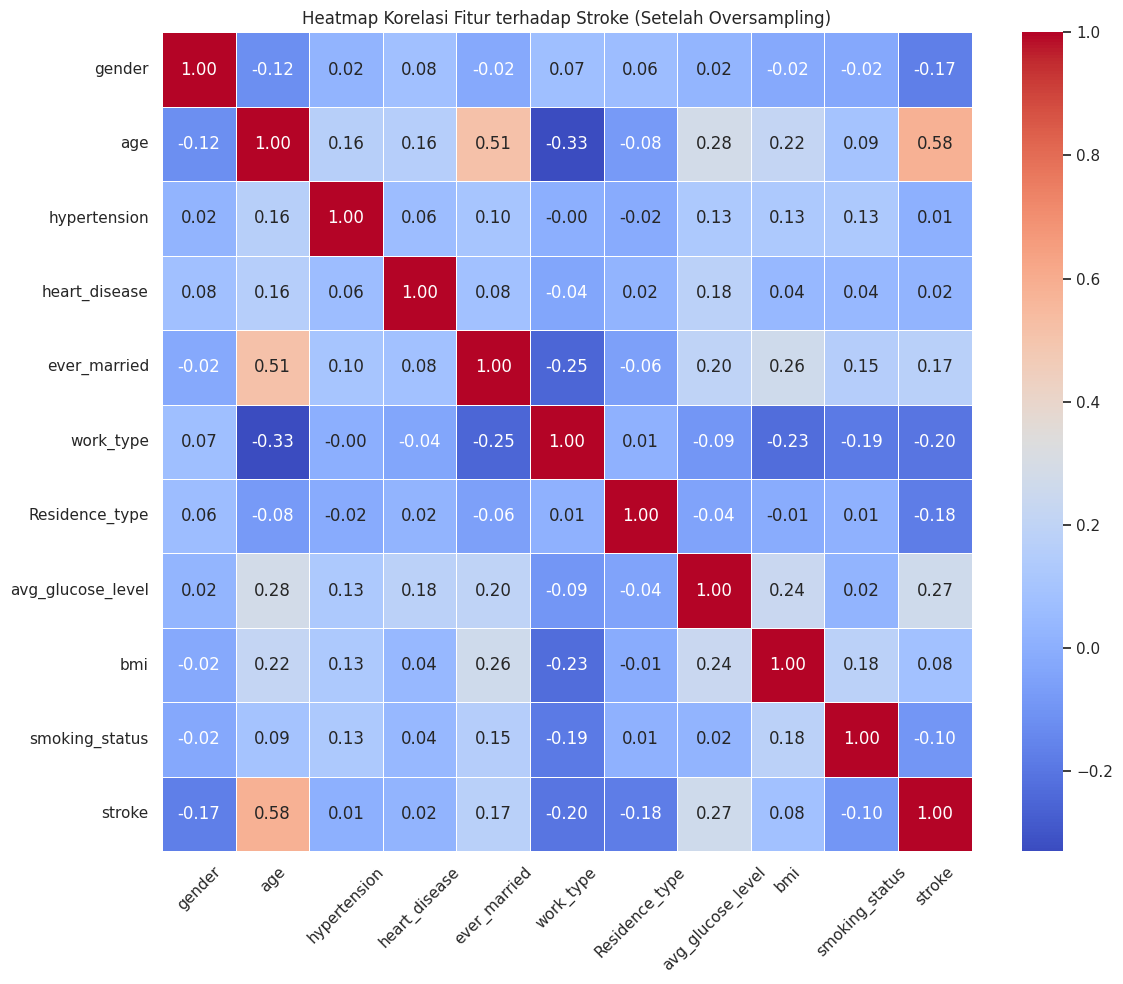

In [17]:
# Hitung matriks korelasi dari data hasil resampling
corr_matrix = df_resampled.corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Fitur terhadap Stroke (Setelah Oversampling)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### DATA SPLIT 

In [18]:
# Split data (setelah oversampling) menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled  # tetap stratifikasi agar distribusi balanced
)

# Cek ukuran data
print("Ukuran data training:", X_train.shape)
print("Ukuran data testing :", X_test.shape)

Ukuran data training: (4373, 10)
Ukuran data testing : (1094, 10)


## Training dan Testing Model SVM

In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Feature Scaling (wajib untuk SVM agar performanya optimal)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inisialisasi model SVM
svm_model = SVC(random_state=42)

# Training model SVM
svm_model.fit(X_train_scaled, y_train)

print("Model SVM selesai dilatih.")


Model SVM selesai dilatih.


In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prediksi terhadap data training
y_train_pred = svm_model.predict(X_train_scaled)

# Evaluasi hasil prediksi pada data training
print("🔍 Evaluasi pada Data Train")

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

print("Akurasi:", accuracy_score(y_train, y_train_pred))


🔍 Evaluasi pada Data Train
Confusion Matrix:
[[2073  356]
 [ 275 1669]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      2429
           1       0.82      0.86      0.84      1944

    accuracy                           0.86      4373
   macro avg       0.85      0.86      0.85      4373
weighted avg       0.86      0.86      0.86      4373

Akurasi: 0.8557054653555911


In [20]:

# Prediksi terhadap data test
y_pred = svm_model.predict(X_test_scaled)

# Evaluasi hasil prediksi
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Akurasi:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[495 113]
 [ 75 411]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       608
           1       0.78      0.85      0.81       486

    accuracy                           0.83      1094
   macro avg       0.83      0.83      0.83      1094
weighted avg       0.83      0.83      0.83      1094

Akurasi: 0.8281535648994516


## Training dan Testing Model Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model Random Forest (tanpa optimasi, pakai default)
rf_model = RandomForestClassifier(random_state=42)

# Training model
rf_model.fit(X_train, y_train)

print("Model Random Forest selesai dilatih.")


Model Random Forest selesai dilatih.


In [58]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prediksi terhadap data training
y_train_pred_rf = rf_model.predict(X_train)

# Evaluasi hasil prediksi pada data training
print("🔍 Evaluasi pada Data Train")

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_rf))

print("\nClassification Report:")
print(classification_report(y_train, y_train_pred_rf))

print("Akurasi:", accuracy_score(y_train, y_train_pred_rf))


🔍 Evaluasi pada Data Train
Confusion Matrix:
[[2429    0]
 [   0 1944]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2429
           1       1.00      1.00      1.00      1944

    accuracy                           1.00      4373
   macro avg       1.00      1.00      1.00      4373
weighted avg       1.00      1.00      1.00      4373

Akurasi: 1.0


In [22]:
# Prediksi terhadap data test
y_pred_rf = rf_model.predict(X_test)

# Evaluasi hasil prediksi
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("Akurasi:", accuracy_score(y_test, y_pred_rf))


Confusion Matrix:
[[543  65]
 [ 43 443]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       608
           1       0.87      0.91      0.89       486

    accuracy                           0.90      1094
   macro avg       0.90      0.90      0.90      1094
weighted avg       0.90      0.90      0.90      1094

Akurasi: 0.9012797074954296


## Training dan Testing Model KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Inisialisasi model KNN (tanpa optimasi, default k=5)
knn_model = KNeighborsClassifier()

# Training model
knn_model.fit(X_train, y_train)

print("Model KNN selesai dilatih.")


Model KNN selesai dilatih.


In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prediksi terhadap data training
y_train_pred_knn = knn_model.predict(X_train)

# Evaluasi hasil prediksi pada data training
print("🔍 Evaluasi pada Data Train")

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_knn))

print("\nClassification Report:")
print(classification_report(y_train, y_train_pred_knn))

print("Akurasi:", accuracy_score(y_train, y_train_pred_knn))


🔍 Evaluasi pada Data Train
Confusion Matrix:
[[2042  387]
 [  35 1909]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      2429
           1       0.83      0.98      0.90      1944

    accuracy                           0.90      4373
   macro avg       0.91      0.91      0.90      4373
weighted avg       0.92      0.90      0.90      4373

Akurasi: 0.9034987422821862


In [24]:
# Prediksi terhadap data test
y_pred_knn = knn_model.predict(X_test)

# Evaluasi hasil prediksi
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

print("Akurasi:", accuracy_score(y_test, y_pred_knn))


Confusion Matrix:
[[464 144]
 [ 22 464]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       608
           1       0.76      0.95      0.85       486

    accuracy                           0.85      1094
   macro avg       0.86      0.86      0.85      1094
weighted avg       0.87      0.85      0.85      1094

Akurasi: 0.8482632541133455


## Optimasi Parameter dengan Particle Swarm Optimization (PSO)

Berikut adalah proses optimasi hyperparameter menggunakan metode Particle Swarm Optimization (PSO) untuk tiga model berikut:

- **SVM**
- **Random Forest**
- **KNN**

Optimasi dilakukan untuk meningkatkan performa model pada data yang telah diimbangi dan dibagi sebelumnya.

---

### SVM Optimasi PSO
Optimasi dilakukan terhadap parameter:
- `C` (Regularization)
- `gamma` (Kernel coefficient)


In [26]:
from sklearn.model_selection import cross_val_score
from pyswarm import pso

In [27]:
from sklearn.model_selection import cross_val_score
from pyswarm import pso

def svm_objective(params):
    C, gamma = params
    model = SVC(C=C, gamma=gamma)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return -scores.mean()

lb = [0.1, 0.0001]
ub = [100, 1]

start_time = time.time()
best_params_svm, _ = pso(svm_objective, lb, ub, swarmsize=10, maxiter=10)
end_time = time.time()

print("Best Params (SVM):", best_params_svm)
print("Waktu Optimasi SVM: {:.2f} detik".format(end_time - start_time))

Stopping search: maximum iterations reached --> 10
Best Params (SVM): [57.97242199  0.18921113]
Waktu Optimasi SVM: 442.01 detik


In [28]:
svm_best = SVC(C=best_params_svm[0], gamma=best_params_svm[1])
svm_best.fit(X_train, y_train)
y_pred_svm_best = svm_best.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_best))
print("Akurasi:", accuracy_score(y_test, y_pred_svm_best))


Confusion Matrix:
[[574  34]
 [ 50 436]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       608
           1       0.93      0.90      0.91       486

    accuracy                           0.92      1094
   macro avg       0.92      0.92      0.92      1094
weighted avg       0.92      0.92      0.92      1094

Akurasi: 0.923217550274223


### Random Forest Optimasi PSO
Optimasi dilakukan terhadap parameter:
- `n_estimators` (jumlah pohon)
- `max_depth` (kedalaman maksimum pohon)

In [29]:
def rf_objective(params):
    n_estimators, max_depth = int(params[0]), int(params[1])
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return -scores.mean()

lb = [10, 2]
ub = [200, 20]

start_time = time.time()
best_params_rf, _ = pso(rf_objective, lb, ub, swarmsize=10, maxiter=10)
end_time = time.time()

print("Best Params (Random Forest):", best_params_rf)
print("Waktu Optimasi RF: {:.2f} detik".format(end_time - start_time))


Stopping search: maximum iterations reached --> 10
Best Params (Random Forest): [164.23330548  20.        ]
Waktu Optimasi RF: 344.08 detik


In [30]:
rf_best = RandomForestClassifier(n_estimators=int(best_params_rf[0]), max_depth=int(best_params_rf[1]), random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_best))
print("Akurasi:", accuracy_score(y_test, y_pred_rf_best))


Confusion Matrix:
[[542  66]
 [ 42 444]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       608
           1       0.87      0.91      0.89       486

    accuracy                           0.90      1094
   macro avg       0.90      0.90      0.90      1094
weighted avg       0.90      0.90      0.90      1094

Akurasi: 0.9012797074954296


### KNN Optimasi PSO
Optimasi dilakukan terhadap parameter:
- `n_neighbors` (jumlah tetangga)

In [32]:
def knn_objective(params):
    k = int(params[0])
    if k < 1:
        return 1
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    fitness = -scores.mean()
    # fitness_history_knn.append(fitness)
    return fitness

lb = [1]
ub = [50]

start_time = time.time()
best_params_knn, _ = pso(knn_objective, lb, ub, swarmsize=10, maxiter=10)
end_time = time.time()

print("Best k (KNN):", best_params_knn)
print("Waktu Optimasi KNN: {:.2f} detik".format(end_time - start_time))


Stopping search: maximum iterations reached --> 10
Best k (KNN): [1.]
Waktu Optimasi KNN: 24.91 detik


In [33]:
knn_best = KNeighborsClassifier(n_neighbors=int(best_params_knn[0]))
knn_best.fit(X_train, y_train)
y_pred_knn_best = knn_best.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn_best))
print("Akurasi:", accuracy_score(y_test, y_pred_knn_best))


Confusion Matrix:
[[505 103]
 [ 18 468]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       608
           1       0.82      0.96      0.89       486

    accuracy                           0.89      1094
   macro avg       0.89      0.90      0.89      1094
weighted avg       0.90      0.89      0.89      1094

Akurasi: 0.8893967093235832


## Optimasi Parameter dengan GridSearchCV

Berikut adalah proses optimasi hyperparameter menggunakan metode GridSearchCV untuk tiga model berikut:

- **SVM**
- **Random Forest**
- **KNN**

Optimasi dilakukan untuk meningkatkan performa model pada data yang telah diimbangi dan dibagi sebelumnya.

---

In [34]:
from sklearn.model_selection import GridSearchCV

### SVM dengan GridSearchCV

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

# Parameter grid untuk SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Mulai pengukuran waktu
start_time = time.time()

# GridSearch untuk SVM
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Waktu eksekusi
end_time = time.time()
print("=== SVM Grid Search ===")
print(f"Best Parameters: {grid_svm.best_params_}")
print(f"Best Score: {grid_svm.best_score_:.4f}")
print(f"Waktu training: {end_time - start_time:.2f} detik")

=== SVM Grid Search ===
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score: 0.9271
Waktu training: 223.99 detik


In [36]:
# Ambil best params
best_params_svm = grid_svm.best_params_

# Buat dan latih model dengan best params
svm_best = SVC(C=best_params_svm['C'], kernel=best_params_svm['kernel'], gamma=best_params_svm['gamma'])
svm_best.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred_svm_best = svm_best.predict(X_test)

print("=== Evaluasi SVM (Best Params) ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_best))
print("Akurasi:", accuracy_score(y_test, y_pred_svm_best))


=== Evaluasi SVM (Best Params) ===
Confusion Matrix:
[[551  57]
 [ 27 459]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       608
           1       0.89      0.94      0.92       486

    accuracy                           0.92      1094
   macro avg       0.92      0.93      0.92      1094
weighted avg       0.92      0.92      0.92      1094

Akurasi: 0.923217550274223


### Random Forest dengan GridSearchCV

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Parameter grid untuk Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

start_time = time.time()

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

end_time = time.time()
print("=== Random Forest Grid Search ===")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score: {grid_rf.best_score_:.4f}")
print(f"Waktu training: {end_time - start_time:.2f} detik")


=== Random Forest Grid Search ===
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9106
Waktu training: 17.25 detik


In [38]:
# Ambil best params
best_params_rf = grid_rf.best_params_

# Buat dan latih model dengan best params
rf_best = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)
rf_best.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred_rf_best = rf_best.predict(X_test)

print("=== Evaluasi Random Forest (Best Params) ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_best))
print("Akurasi:", accuracy_score(y_test, y_pred_rf_best))


=== Evaluasi Random Forest (Best Params) ===
Confusion Matrix:
[[545  63]
 [ 41 445]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       608
           1       0.88      0.92      0.90       486

    accuracy                           0.90      1094
   macro avg       0.90      0.91      0.90      1094
weighted avg       0.91      0.90      0.91      1094

Akurasi: 0.9049360146252285


### KNN dengan GridSearchCV

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# Parameter grid untuk KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

start_time = time.time()

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

end_time = time.time()
print("=== KNN Grid Search ===")
print(f"Best Parameters: {grid_knn.best_params_}")
print(f"Best Score: {grid_knn.best_score_:.4f}")
print(f"Waktu training: {end_time - start_time:.2f} detik")


=== KNN Grid Search ===
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.8795
Waktu training: 1.13 detik


In [40]:
# Ambil best params
best_params_knn = grid_knn.best_params_

# Buat dan latih model dengan best params
knn_best = KNeighborsClassifier(
    n_neighbors=best_params_knn['n_neighbors'],
    weights=best_params_knn['weights'],
    metric=best_params_knn['metric']
)
knn_best.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred_knn_best = knn_best.predict(X_test)

print("=== Evaluasi KNN (Best Params) ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn_best))
print("Akurasi:", accuracy_score(y_test, y_pred_knn_best))


=== Evaluasi KNN (Best Params) ===
Confusion Matrix:
[[482 126]
 [ 15 471]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       608
           1       0.79      0.97      0.87       486

    accuracy                           0.87      1094
   macro avg       0.88      0.88      0.87      1094
weighted avg       0.89      0.87      0.87      1094

Akurasi: 0.8711151736745887


## Optimasi Parameter dengan Genetic Algorithm (GA)

Berikut adalah proses optimasi hyperparameter menggunakan metode Genetic Algorithm (GA) untuk tiga model berikut:

- **SVM**
- **Random Forest**
- **KNN**

Optimasi dilakukan untuk meningkatkan performa model pada data yang telah diimbangi dan dibagi sebelumnya.

---

In [41]:
from geneticalgorithm import geneticalgorithm as ga

### SVM dengan GA

 The best solution found:                                                                           
 [2.04931373 0.19299008]

 Objective function:
 -0.9350556390977444


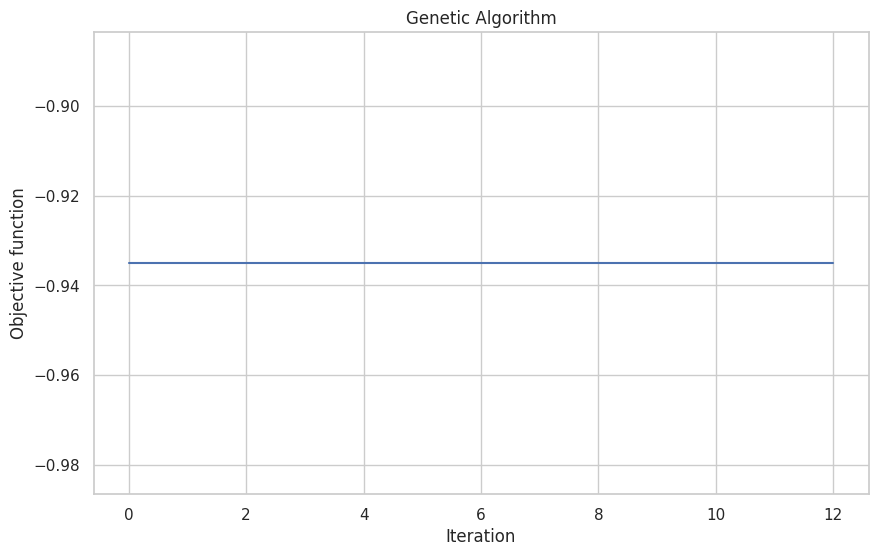


Waktu optimasi SVM (GA): 339.16 detik
Best Parameters (C, gamma): [2.04931373 0.19299008]


In [42]:
# Fungsi fitness untuk SVM
def fitness_svm(params):
    C, gamma = params
    model = SVC(C=float(C), gamma=float(gamma), kernel='rbf')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return -scores.mean()

# Batas parameter [min, max]
varbound_svm = np.array([[0.1, 10], [0.0001, 1]])

# Setup GA
model_svm = ga(
    function=fitness_svm,
    dimension=2,
    variable_type='real',
    variable_boundaries=varbound_svm,
    algorithm_parameters={
        'max_num_iteration': 20,
        'population_size': 10,
        'mutation_probability': 0.1,
        'elit_ratio': 0.01,
        'crossover_probability': 0.5,
        'parents_portion': 0.3,
        'crossover_type': 'uniform',
        'max_iteration_without_improv': 10
    },
    function_timeout=30
)

start_time = time.time()
model_svm.run()
end_time = time.time()

# Ambil parameter terbaik
best_params_svm_GA = model_svm.output_dict['variable']
print(f"\nWaktu optimasi SVM (GA): {end_time - start_time:.2f} detik")
print(f"Best Parameters (C, gamma): {best_params_svm_GA}")


In [43]:
# Evaluasi model terbaik
svm_best = SVC(C=best_params_svm_GA[0], gamma=best_params_svm_GA[1], kernel='rbf')
svm_best.fit(X_train, y_train)
y_pred_svm_best = svm_best.predict(X_test)

print("\n=== Evaluasi SVM (GA) ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_best))
print("Akurasi:", accuracy_score(y_test, y_pred_svm_best))


=== Evaluasi SVM (GA) ===
Confusion Matrix:
[[574  34]
 [ 53 433]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       608
           1       0.93      0.89      0.91       486

    accuracy                           0.92      1094
   macro avg       0.92      0.92      0.92      1094
weighted avg       0.92      0.92      0.92      1094

Akurasi: 0.9204753199268738


### Random Forest dengan GA

 The best solution found:                                                                           
 [194.  28.]

 Objective function:
 -0.9105872507355345


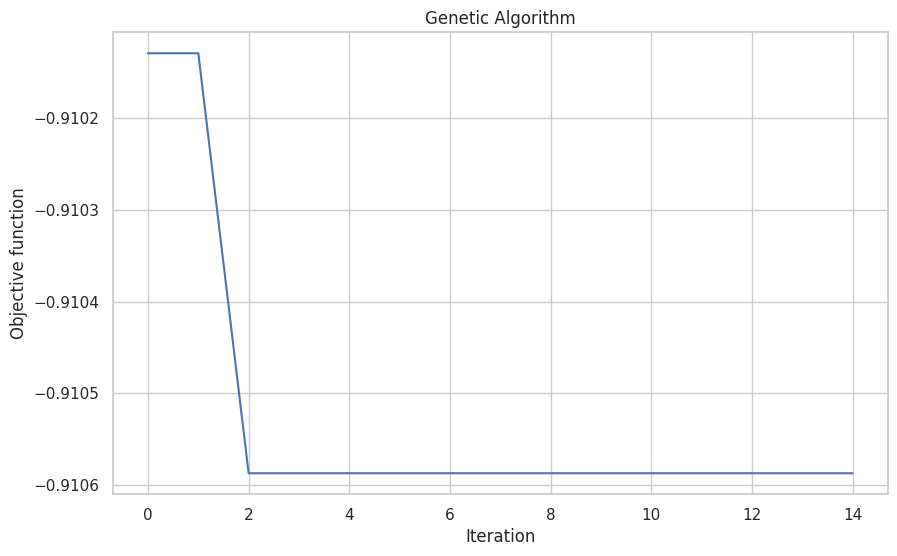


Waktu optimasi RF (GA): 347.01 detik
Best Parameters (n_estimators, max_depth): [194.  28.]


In [44]:
# Fungsi fitness untuk RF
def fitness_rf(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return -scores.mean()

varbound_rf = np.array([[50, 200], [2, 30]])

model_rf = ga(function=fitness_rf,
              dimension=2,
              variable_type='int',
              variable_boundaries=varbound_rf,
              algorithm_parameters={'max_num_iteration': 50, 'population_size': 10, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type':'uniform', 'max_iteration_without_improv':10})

start_time = time.time()
model_rf.run()
end_time = time.time()

best_params_rf_GA = model_rf.output_dict['variable']
print(f"\nWaktu optimasi RF (GA): {end_time - start_time:.2f} detik")
print(f"Best Parameters (n_estimators, max_depth): {best_params_rf_GA}")

In [45]:
rf_best = RandomForestClassifier(n_estimators=int(best_params_rf_GA[0]), max_depth=int(best_params_rf_GA[1]), random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_test)

print("\n=== Evaluasi Random Forest (GA) ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_best))
print("Akurasi:", accuracy_score(y_test, y_pred_rf_best))


=== Evaluasi Random Forest (GA) ===
Confusion Matrix:
[[544  64]
 [ 42 444]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       608
           1       0.87      0.91      0.89       486

    accuracy                           0.90      1094
   macro avg       0.90      0.90      0.90      1094
weighted avg       0.90      0.90      0.90      1094

Akurasi: 0.903107861060329


### KNN dengan GA

 The best solution found:                                                                           
 [1.]

 Objective function:
 -0.8943521412226219


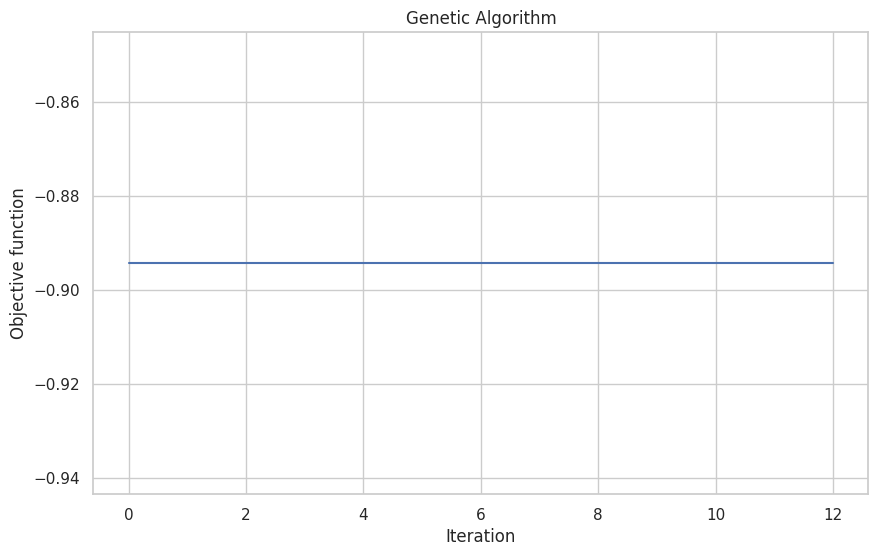


Waktu optimasi KNN (GA): 20.22 detik
Best Parameter (n_neighbors): [1.]


In [46]:
# Fungsi fitness untuk KNN
def fitness_knn(params):
    n_neighbors = int(params[0])
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return -scores.mean()

varbound_knn = np.array([[1, 15]])

model_knn = ga(function=fitness_knn,
               dimension=1,
               variable_type='int',
               variable_boundaries=varbound_knn,
               algorithm_parameters={'max_num_iteration': 50, 'population_size': 10, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type':'uniform', 'max_iteration_without_improv':10})

start_time = time.time()
model_knn.run()
end_time = time.time()

best_params_knn_GA = model_knn.output_dict['variable']
print(f"\nWaktu optimasi KNN (GA): {end_time - start_time:.2f} detik")
print(f"Best Parameter (n_neighbors): {best_params_knn_GA}")

In [47]:
knn_best = KNeighborsClassifier(n_neighbors=int(best_params_knn_GA[0]))
knn_best.fit(X_train, y_train)
y_pred_knn_best = knn_best.predict(X_test)

print("\n=== Evaluasi KNN (GA) ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn_best))
print("Akurasi:", accuracy_score(y_test, y_pred_knn_best))


=== Evaluasi KNN (GA) ===
Confusion Matrix:
[[505 103]
 [ 18 468]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       608
           1       0.82      0.96      0.89       486

    accuracy                           0.89      1094
   macro avg       0.89      0.90      0.89      1094
weighted avg       0.90      0.89      0.89      1094

Akurasi: 0.8893967093235832


## Komparasi Hasil

In [51]:
# Data for the comparison table
# Metrics are generally (Precision, Recall, F1-Score, Accuracy) from weighted averages
# Time is in seconds
data = {
    'Model': [
        'SVM (baseline)', 'SVM + PSO', 'SVM + GRID', 'SVM + GA',
        'RF (baseline)', 'RF + PSO', 'RF + GRID', 'RF + GA',
        'KNN (baseline)', 'KNN + PSO', 'KNN + GRID', 'KNN + GA'
    ],
    'Precision': [
        0.83, 0.92, 0.92, 0.92,  # SVM
        0.90, 0.90, 0.91, 0.90,  # RF
        0.87, 0.90, 0.89, 0.90   # KNN
    ],
    'Recall': [
        0.83, 0.92, 0.92, 0.92,  # SVM
        0.90, 0.90, 0.90, 0.90,  # RF
        0.85, 0.89, 0.87, 0.89   # KNN
    ],
    'F1-Score': [
        0.83, 0.92, 0.92, 0.92,  # SVM
        0.90, 0.90, 0.91, 0.90,  # RF
        0.85, 0.89, 0.87, 0.89   # KNN
    ],
    'Accuracy': [
        0.8281, 0.9232, 0.9232, 0.9204, # SVM
        0.9012, 0.9012, 0.9049, 0.9031, # RF
        0.8482, 0.8893, 0.8711, 0.8893  # KNN
    ],
    'Parameters': [
        "default", "C=57.97, gamma=0.18", "C=10, gamma=auto", "C=2.04, gamma=0.19",
        "default", "n_est=164, max_depth=20", "n_est=200, max_depth=None", "n_est=194, max_depth=28",
        "default", "n_neighbors=1", "n_neighbors=3", "n_neighbors=1"
    ],
    'Time (s)': [
        1.2, 442.01, 223.99, 339.16, 
        0.9, 344.08, 17.25, 347.01, 
        0.5, 24.91, 1.13, 20.22     
    ]
}

comparison_df = pd.DataFrame(data)

print("Tabel Komparasi Model Machine Learning")
print(comparison_df.to_string())


Tabel Komparasi Model Machine Learning
             Model  Precision  Recall  F1-Score  Accuracy                 Parameters  Time (s)
0   SVM (baseline)       0.83    0.83      0.83    0.8281                    default      1.20
1        SVM + PSO       0.92    0.92      0.92    0.9232        C=57.97, gamma=0.18    442.01
2       SVM + GRID       0.92    0.92      0.92    0.9232           C=10, gamma=auto    223.99
3         SVM + GA       0.92    0.92      0.92    0.9204         C=2.04, gamma=0.19    339.16
4    RF (baseline)       0.90    0.90      0.90    0.9012                    default      0.90
5         RF + PSO       0.90    0.90      0.90    0.9012    n_est=164, max_depth=20    344.08
6        RF + GRID       0.91    0.90      0.91    0.9049  n_est=200, max_depth=None     17.25
7          RF + GA       0.90    0.90      0.90    0.9031    n_est=194, max_depth=28    347.01
8   KNN (baseline)       0.87    0.85      0.85    0.8482                    default      0.50
9        KN

## KESIMPULAN

Berdasarkan hasil perbandingan performa model machine learning untuk prediksi stroke, beberapa kesimpulan penting dapat ditarik:

**Performa Model Secara Umum:**
* **Support Vector Machine (SVM) yang dioptimasi menunjukkan performa terbaik** dalam hal metrik evaluasi (Precision, Recall, F1-Score, dan Accuracy) selalu konsisten di 0.92.
* **K-Nearest Neighbors (KNN)**, meskipun menunjukkan peningkatan signifikan setelah optimasi, secara umum memiliki performa sedikit di bawah SVM dan RF yang teroptimasi.
* **Model baseline (tanpa optimasi)** secara konsisten memberikan performa yang lebih rendah dibandingkan versi yang telah dioptimasi, menyoroti pentingnya proses tuning hyperparameter. SVM baseline memiliki performa terendah diantara baseline model lainnya.

**Efektivitas Metode Optimasi:**
* **Particle Swarm Optimization (PSO), GridSearchCV dan Genetic Algorithm (GA)** berhasil meningkatkan performa SVM hingga mencapai akurasi (0.92). Ini menunjukkan potensi besar dari algoritma metaheuristik untuk menemukan parameter optimal pada model SVM dalam dataset ini.
* **GridSearchCV** juga sangat efektif, menghasilkan peningkatan signifikan pada semua model, terutama pada SVM dan RF. Untuk SVM, GridSearchCV memberikan hasil yang sama dengan PSO namun dengan waktu training yang jauh lebih cepat dibandingkan PSO dan GA.
* **PSO dan GA** juga meningkatkan performa semua model. Pada KNN, PSO dan GA berhasil meraih performa yang lebih baik dibandingkan dengan GridSearchCV. Namun GA memiliki keunggulan di waktu komputasi yang lebih cepat.

**Waktu Komputasi:**
* **Model baseline** memiliki waktu training yang paling singkat, yang diharapkan karena tidak ada proses optimasi yang intensif.
* **GridSearchCV pada KNN** menunjukkan waktu optimasi yang sangat cepat (1.13 detik), menjadikannya pilihan yang efisien. Untuk Random Forest, GridSearchCV juga relatif cepat (17.25 detik).
* **PSO pada SVM dan GA pada RF** membutuhkan waktu optimasi yang paling lama (PSO - SVM: 442.01 detik) diikuti oleh (GA - RF 347.01 detik). Meskipun menghasilkan performa tinggi, pertimbangan waktu komputasi menjadi penting.
* **GridSearhCV secara umum menunjukkan waktu yang lebih cepat dibandingkan PSO dan GA** dalam mencapai performa yang sebanding atau bahkan lebih baik (khususnya untuk RF).

**Pilihan Model Terbaik:**
* Jika **akurasi tertinggi dan waktu komputasi** adalah prioritas utama, **SVM yang dioptimasi dengan GridSearchCV** (mencapai akurasi tertinggi 0.9232) adalah pilihan terbaik.
* **Random Forest yang dioptimasi dengan GridSearchCV** menawarkan keseimbangan yang sangat baik antara performa tinggi (akurasi 0.9049) dan waktu training yang relatif cepat (17.25 detik). Ini menjadikannya kandidat kuat untuk implementasi praktis.

**Kesimpulan Akhir:**
Secara keseluruhan, optimasi hyperparameter terbukti krusial dalam meningkatkan performa model. SVM yang dioptimasi dengan GridSearchCV muncul sebagai pilihan yang paling baik antara akurasi dan efisiensi waktu untuk dataset ini.

In [54]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# Best parameters
best_C = 10
best_gamma = 'auto'

# Scaling fitur (jika diperlukan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inisialisasi model SVM dengan best params
svm_best = SVC(
    C=best_C,
    gamma=best_gamma,
    probability=True,  # Jika ingin menyimpan .predict_proba()
    random_state=42
)

# Train model
svm_best.fit(X_train_scaled, y_train)

# Buat pipeline agar scaler dan model ikut disimpan
svm_pipeline = Pipeline([
    ('scaler', scaler),
    ('svm', svm_best)
])

# Simpan ke file .pkl
joblib.dump(svm_pipeline, 'svm_stroke_model.pkl')

print("✅ Model SVM dengan best params berhasil disimpan sebagai svm_stroke_model.pkl")


✅ Model SVM dengan best params berhasil disimpan sebagai svm_stroke_model.pkl


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# Bulatkan best params
best_n_estimators = int(200)
best_max_depth = None

# Scaling fitur (jika diperlukan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inisialisasi model RF dengan best params
rf_best = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    random_state=42
)

# Train model
rf_best.fit(X_train_scaled, y_train)

# Buat pipeline agar scaler dan model ikut disimpan
rf_pipeline = Pipeline([
    ('scaler', scaler),
    ('rf', rf_best)
])

# Simpan ke file .pkl
joblib.dump(rf_pipeline, 'rf_stroke_model.pkl')

print("✅ Model Random Forest dengan best params berhasil disimpan sebagai rf_stroke_model.pkl")


✅ Model Random Forest dengan best params berhasil disimpan sebagai rf_stroke_model.pkl


In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

# Best parameter
best_n_neighbors = 1

# Scaling fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Opsional, jika ingin digunakan untuk evaluasi

# Inisialisasi model KNN dengan best param
knn_best = KNeighborsClassifier(n_neighbors=best_n_neighbors)

# Latih model
knn_best.fit(X_train_scaled, y_train)

# Buat pipeline agar scaler dan model ikut disimpan
knn_pipeline = Pipeline([
    ('scaler', scaler),
    ('knn', knn_best)
])

# Simpan ke file .pkl
joblib.dump(knn_pipeline, 'knn_stroke_model.pkl')

print("✅ Model KNN dengan best param (n_neighbors=1) berhasil disimpan sebagai knn_stroke_model.pkl")


✅ Model KNN dengan best param (n_neighbors=1) berhasil disimpan sebagai knn_stroke_model.pkl
